<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Tuning a neural network</h2>

This notebook is a playground for tuning a neural network. Try to get a feeling how different operations behave! Some things have to be tried out :) What's the highest score on MNIST you can get?

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import os

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.0+cu124
True


In [3]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, 
                       test_batch_size=1000, 
                       epochs=1,
                       lr=0.01, 
                       momentum=0.5, 
                       seed=1, 
                       log_interval=100)

torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [4]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.


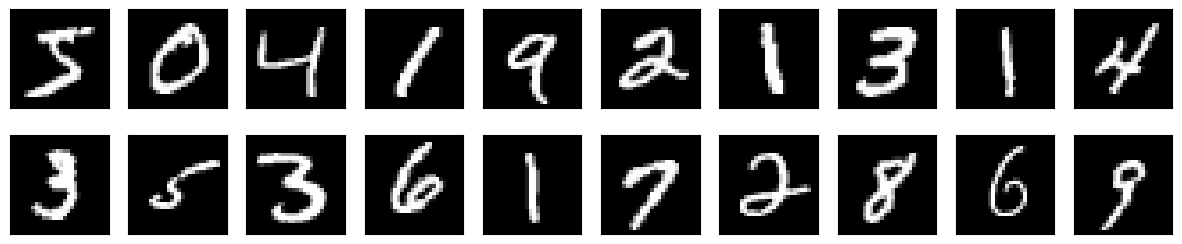

In [5]:
print(train_loader.dataset.targets.shape)
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

<h3 style="color:rgb(0,120,170)"> Task 3.1 </h3>
Here an architecture is provided. You can play around with number of layers, number of units, weight initialization, dropout, batch normalization, activation functions... You should develop a feeling on the effects of your changes. What's the highest score you can get?

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, D_in, D_out):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(D_in, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, D_out)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.linear4.weight)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.2)
        self.dropout4 = nn.Dropout(p=0.2)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn3 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.linear3(x)
        x = self.dropout3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.linear4(x)
        x = self.dropout4(x)
        return F.log_softmax(x, dim=1)

In [7]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = Variable(data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [9]:
# Main
model = NeuralNet(input_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum, weight_decay=0.005)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.941970
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.963507
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.990597
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.160894
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.888075
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.881130
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.843553
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.064642
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.771081
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.779998

Test set: Average loss: 0.2137, Accuracy: 9389/10000 (93.89%)

